In [ ]:
from mp_api.client import MPRester
from emmet.core.summary import HasProps, summary_fields

API = "05pwL0aLyXiEGNsZRFhKcju39mwEqbz8"

necessary_field = ['material_id', 'formula_pretty','formula_anonymous', 'structure']
wanted_field = summary_fields['thermo']+summary_fields['dielectric']
wanted_properties = [HasProps.dielectric]

with MPRester(API) as mpr:
    docs = mpr.materials.summary.search(
        has_props = wanted_properties, fields=necessary_field+wanted_field
    )

In [ ]:
import pandas as pd

# Converting the data raw data into dataframe
materials = []
for material in docs:
  material = dict(material)
  materials.append(material)
df = pd.DataFrame(materials)
df = df[necessary_field+wanted_field]
del df['decomposes_to']
df = df.dropna()
df.head()

In [ ]:
df.describe()

## Saving data and importing data

In [ ]:
from pymatgen.io.cif import CifWriter
structure_cif = []
for index, row in df.iterrows():
    structure = row["structure"]
    cif_writer = CifWriter(structure)
    cif_string = cif_writer.__str__()
    structure_cif.append(cif_string)

df['structure']=structure_cif

filepath = "Database"
filename = "DataBase.xlsx"

# Save the DataFrame to an Excel file
df.to_excel(filepath+"/"+filename, index=False)

```
from pymatgen.io.cif import CifParser


filepath = "<Fill your file path>"
filename = "<Fill your file name>.csv"

# Save the DataFrame to an Excel file
df = pd.read_csv(filepath+"/"+filename)

# Function to convert CIF string to PyMatGen structure
def cif_to_structure(cif_string):
    try:
        parser = CifParser.from_string(cif_string)
        structure = parser.get_structures()[0]  # Assuming there's only one structure in the CIF
        return structure
    except Exception as e:
        return None

# Apply the function to create a new 'structure' column
df['structure                  n                                  
                                                                  
                                                                   '] = df['structure'].apply(cif_to_structure)

# Print the DataFrame with the new 'structure' column
df.head()
```

# Importing Data

In [ ]:
import pandas as pd

df = pd.read_excel('./Database/DataBase.xlsx')
df.head()

# Applied Descriptors

In [ ]:
# Str to composition descriptor
from matminer.featurizers.conversions import StrToComposition

df = StrToComposition().featurize_dataframe(df, "formula_pretty")
df.head()

# Formula Fraction

In [ ]:
# Element Fraction Descriptor
from matminer.featurizers.composition import ElementFraction

df_fraction = df.copy()
df_fraction = ElementFraction().featurize_dataframe(df_fraction, col_id="composition") # input the "composition" column to the featurizer

In [ ]:
df_fraction.head()

# Element Property Prediction

In [ ]:
from matminer.featurizers.composition import ElementProperty

df_el_prop = df.copy()

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df_el_prop = ep_feat.featurize_dataframe(df_el_prop, col_id="composition")  # input the "composition" column to the featurizer
df_el_prop.head()

# Preparing data for machine learning

In [ ]:
import numpy as np

y = df_fraction['formation_energy_per_atom']
excluded = np.array(df.columns)

X_el = df_el_prop.drop(excluded, axis=1)
X_frac = df_fraction.drop(excluded, axis=1)

_, feat_col_el = X_el.shape
_, feat_col_frac = X_frac.shape

In [ ]:
el = np.array(X_el.columns.values)
frac = np.array(X_frac.columns.values)

np.save("TrainingData/el_col.npy", el)
np.save("TrainingData/frac_col.npy", frac)

In [ ]:
print("There are {} possible descriptors:\n\n{}".format(X_el.shape[1], X_el.columns.values))

In [ ]:
print("There are {} possible descriptors:\n\n{}".format(X_frac.shape[1], X_frac.columns.values))

# Saving training data

In [ ]:
# Save to disk for later training
np.save("TrainingData/X_el.npy", X_el)
np.save("TrainingData/X_frac.npy", X_frac)
np.save("TrainingData/y.npy", y)

# Xgboost

## Element Property

In [62]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
X_el = np.load("TrainingData/X_el.npy")
y = np.load("TrainingData/y.npy")

el = np.load("TrainingData/el_col.npy", allow_pickle=True) # allow_pickel = True when you input string data

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_el, y, test_size=0.2, random_state=42)

In [ ]:
# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)


### Saving and uploading the model

In [ ]:
import xgboost as xgb
import pickle

In [ ]:
# Save the model to a file using pickle
with open("Models/el_xgboost.pkl", "wb") as model_file:
    pickle.dump(model, model_file)


### Graph

In [ ]:
# Load the model from the saved file
with open("Models/el_xgboost.pkl", "rb") as model_file:
    model = pickle.load(model_file)
    
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE value as text in the graph
plt.text(0.1, 0.9, mse_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.7, "Element Property Magpiedata", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig("Images/el_xgboost.png")  # Save the plot to a file
plt.show()

### Adding R2 score

In [ ]:
from sklearn.metrics import r2_score

# Load the model from the saved file
with open("Models/el_xgboost.pkl", "rb") as model_file:
   model = pickle.load(model_file)
   
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
r2_text = f"R2 Score: {r2:.2f}"

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE and R2 values as text in the graph
plt.text(0.1, 0.9, mse_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.8, r2_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.7, "Element Property Magpiedata", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig("Images/el_xgboost_r2.png") # Save the plot to a file
plt.show()


In [ ]:
# Load the model from the saved file
with open("Models/el_xgboost.pkl", "rb") as model_file:
  model = pickle.load(model_file)
  
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
r2_text = f"R2 Score: {r2:.2f}"

# Calculate the slope and intercept of the line that best fits the data
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(y_test.reshape(-1, 1), y_pred)
slope, intercept = lr.coef_[0], lr.intercept_

# Calculate the absolute differences
diff = np.abs(y_test - y_pred)

# Create a colormap and use it to map the absolute differences to colors
cmap = plt.cm.get_cmap('viridis')
colors = cmap(diff / np.max(diff))

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=colors, alpha=0.5)
plt.plot(y_test, slope * y_test + intercept, linestyle='dashed')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE and R2 values as text in the graph
plt.text(0.1, 0.9, mse_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.8, r2_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.7, "Element Property Magpiedata", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig("Images/el_xgboost.png") # Save the plot to a file
plt.show()


/tmp/ipykernel_298806/1928755848.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot')
/tmp/ipykernel_298806/1928755848.py:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


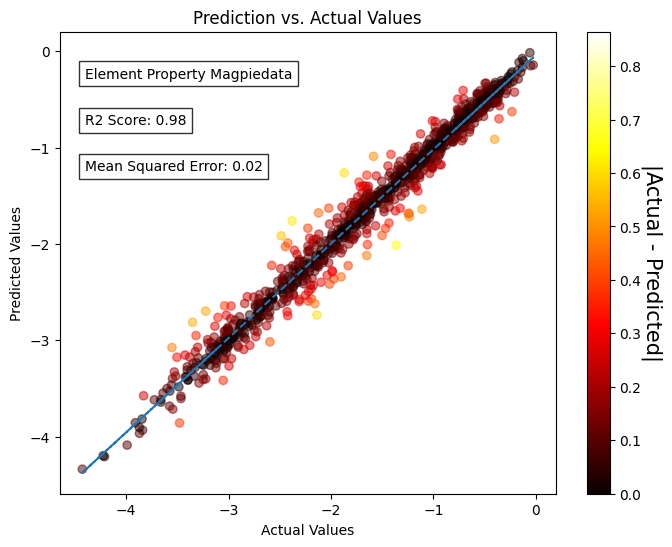

In [63]:
# Load the model from the saved file
with open("Models/el_xgboost.pkl", "rb") as model_file:
 model = pickle.load(model_file)
 
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
r2_text = f"R2 Score: {r2:.2f}"

# Calculate the slope and intercept of the line that best fits the data
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(y_test.reshape(-1, 1), y_pred)
slope, intercept = lr.coef_[0], lr.intercept_

# Calculate the absolute differences
diff = np.abs(y_test - y_pred)

# Normalize the absolute differences
norm = plt.Normalize(vmin=0, vmax=np.max(diff))

# Create a colormap and use it to map the absolute differences to colors
cmap = plt.cm.get_cmap('hot')
colors = cmap(norm(diff))

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=colors, alpha=0.5)
plt.plot(y_test, slope * y_test + intercept, linestyle='dashed')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE and R2 values as text in the graph
plt.text(0.05, 0.7, mse_text, transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.05, 0.8, r2_text, transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.05, 0.9, "Element Property Magpiedata", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('|Actual - Predicted|', rotation=270, fontsize=15, labelpad=15)

plt.savefig("Images/el_xgboost.png") # Save the plot to a file
plt.show()


### Feature importance

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Get feature names (assuming your feature names are stored in a list)
feature_names = el

# Sort the feature importances and select the top ten
sorted_idx = np.argsort(importances)[::-1]
top_ten_indices = sorted_idx[:10]
top_ten_importances = importances[top_ten_indices]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices]

# Create a bar graph for feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_ten_feature_names, top_ten_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top Ten Feature Importance")
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.savefig("Images/el_Xgboost_feat.png")  # Save the plot to a file
plt.show()

### Model Analysist

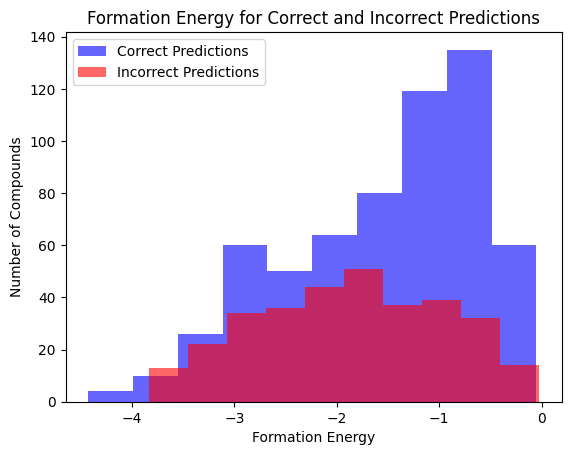

In [8]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the data
X_el = np.load("TrainingData/X_el.npy")
y = np.load("TrainingData/y.npy")

el = np.load("TrainingData/el_col.npy", allow_pickle=True) # allow_pickel = True when you input string data

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_el, y, test_size=0.2, random_state=42)

# Load the model from the saved file
with open("Models/el_xgboost.pkl", "rb") as model_file:
 model = pickle.load(model_file)
 
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

threshold = 0.1 # adjust this value based on your specific use case
correct_predictions = np.abs(y_test - y_pred) < threshold
incorrect_predictions = np.abs(y_test - y_pred) >= threshold


plt.hist(y_test[correct_predictions], bins=10, alpha=0.6, color='b', label='Correct Predictions')
plt.hist(y_test[incorrect_predictions], bins=10, alpha=0.6, color='r', label='Incorrect Predictions')
plt.title('Formation Energy for Correct and Incorrect Predictions')
plt.xlabel('Formation Energy')
plt.ylabel('Number of Compounds')
plt.legend()
plt.show()


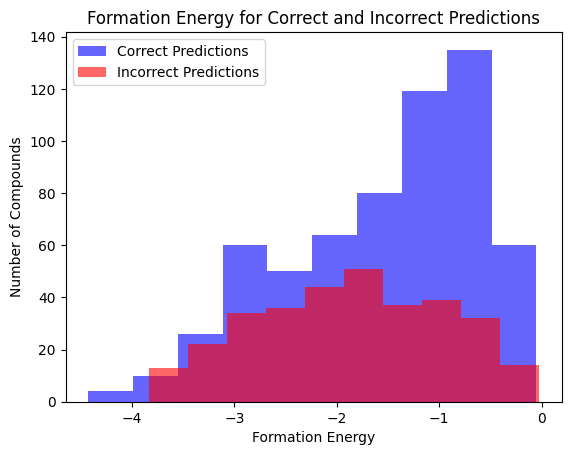

In [9]:
threshold = 0.1 # adjust this value based on your specific use case
correct_predictions = np.abs(y_test - y_pred) < threshold
incorrect_predictions = np.abs(y_test - y_pred) >= threshold


plt.hist(y_test[correct_predictions], bins=10, alpha=0.6, color='b', label='Correct Predictions')
plt.hist(y_test[incorrect_predictions], bins=10, alpha=0.6, color='r', label='Incorrect Predictions')
plt.title('Formation Energy for Correct and Incorrect Predictions')
plt.xlabel('Formation Energy')
plt.ylabel('Number of Compounds')
plt.legend()
plt.show()


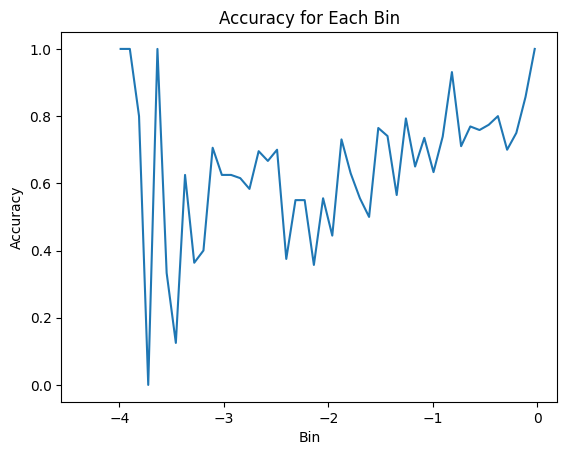

In [10]:
import numpy as np

# Define the number of bins
num_bins = 50

# Calculate the bin edges
bin_edges = np.linspace(y_test.min(), y_test.max(), num_bins + 1)

# Assign each value in y_test to a bin
bin_indices = np.digitize(y_test, bin_edges)

# Initialize an array to store the accuracy for each bin
bin_accuracies = np.zeros(num_bins)

# Calculate the accuracy for each bin
for i in range(1, num_bins + 1):
   # Get the indices of the values in the current bin
   indices = np.where(bin_indices == i)[0]

   # Get the correct predictions for the current bin
   correct_predictions = np.abs(y_test[indices] - y_pred[indices]) < threshold

   # Calculate the accuracy for the current bin
   bin_accuracies[i - 1] = np.mean(correct_predictions)

import matplotlib.pyplot as plt

# Plot the accuracy for each bin
plt.plot(bin_edges[1:], bin_accuracies)

plt.title('Accuracy for Each Bin')
plt.xlabel('Bin')
plt.ylabel('Accuracy')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


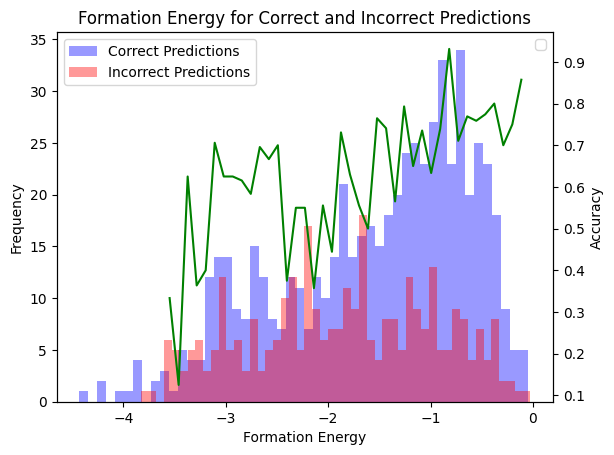

In [13]:
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

threshold = 0.1 # adjust this value based on your specific use case
correct_predictions = np.abs(y_test - y_pred) < threshold
incorrect_predictions = np.abs(y_test - y_pred) >= threshold

fig, ax1 = plt.subplots()
ax1.hist(y_test[correct_predictions], bins=50, alpha=0.4, color='b', label='Correct Predictions')
ax1.hist(y_test[incorrect_predictions], bins=50, alpha=0.4, color='r', label='Incorrect Predictions')
ax1.legend()

ax2 = ax1.twinx() # create a second y-axis
ax2.plot(bin_edges[10:-1], bin_accuracies[9:-1], color='g')

ax1.set_xlabel('Formation Energy')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Accuracy')

plt.title('Formation Energy for Correct and Incorrect Predictions')
plt.legend()
plt.savefig("Images/el_xgboost_analysist.png") # Save the plot to a file
plt.show()


## Element Fraction

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
X_frac = np.load("TrainingData/X_frac.npy")
y = np.load("TrainingData/y.npy")

frac = np.load("TrainingData/frac_col.npy", allow_pickle=True) # allow_pickel = True when you input string data

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_frac, y, test_size=0.2, random_state=42)

In [ ]:
# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)


### Model Performance

/home/andi/.conda/envs/MachineLearning/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [14:01:05] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


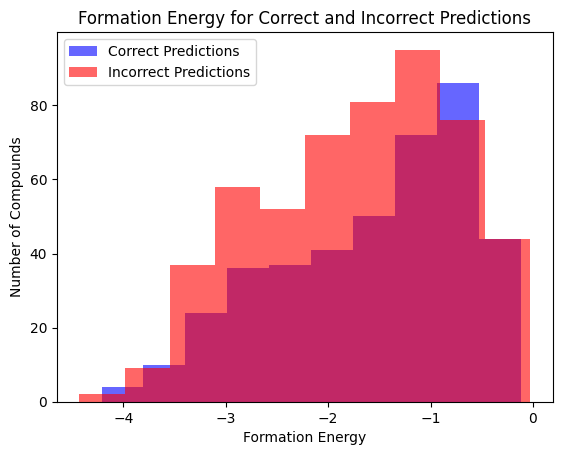

In [1]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the data
X_frac = np.load("TrainingData/X_frac.npy")
y = np.load("TrainingData/y.npy")

frac = np.load("TrainingData/frac_col.npy", allow_pickle=True) # allow_pickel = True when you input string data

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_frac, y, test_size=0.2, random_state=42)

# Load the model from the saved file
with open("Models/frac_xgboost.pkl", "rb") as model_file:
 model = pickle.load(model_file)
 
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

threshold = 0.1 # adjust this value based on your specific use case
correct_predictions = np.abs(y_test - y_pred) < threshold
incorrect_predictions = np.abs(y_test - y_pred) >= threshold


plt.hist(y_test[correct_predictions], bins=10, alpha=0.6, color='b', label='Correct Predictions')
plt.hist(y_test[incorrect_predictions], bins=10, alpha=0.6, color='r', label='Incorrect Predictions')
plt.title('Formation Energy for Correct and Incorrect Predictions')
plt.xlabel('Formation Energy')
plt.ylabel('Number of Compounds')
plt.legend()
plt.show()


In [2]:
# Define the number of bins
num_bins = 50

# Calculate the bin edges
bin_edges = np.linspace(y_test.min(), y_test.max(), num_bins + 1)

# Assign each value in y_test to a bin
bin_indices = np.digitize(y_test, bin_edges)

# Initialize an array to store the accuracy for each bin
bin_accuracies = np.zeros(num_bins)

# Calculate the accuracy for each bin
for i in range(1, num_bins + 1):
   # Get the indices of the values in the current bin
   indices = np.where(bin_indices == i)[0]

   # Get the correct predictions for the current bin
   correct_predictions = np.abs(y_test[indices] - y_pred[indices]) < threshold

   # Calculate the accuracy for the current bin
   bin_accuracies[i - 1] = np.mean(correct_predictions)

/home/andi/.conda/envs/MachineLearning/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andi/.conda/envs/MachineLearning/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


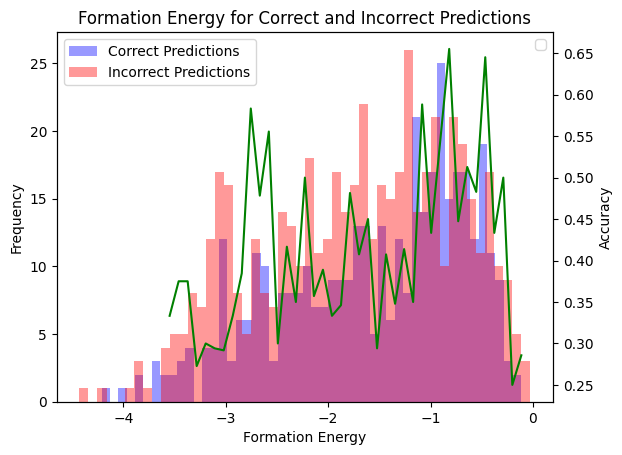

In [7]:
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

threshold = 0.1 # adjust this value based on your specific use case
correct_predictions = np.abs(y_test - y_pred) < threshold
incorrect_predictions = np.abs(y_test - y_pred) >= threshold

fig, ax1 = plt.subplots()
ax1.hist(y_test[correct_predictions], bins=50, alpha=0.4, color='b', label='Correct Predictions')
ax1.hist(y_test[incorrect_predictions], bins=50, alpha=0.4, color='r', label='Incorrect Predictions')
ax1.legend()

ax2 = ax1.twinx() # create a second y-axis
ax2.plot(bin_edges[10:-1], bin_accuracies[9:-1], color='g')

ax1.set_xlabel('Formation Energy')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Accuracy')

plt.title('Formation Energy for Correct and Incorrect Predictions')
plt.legend()
plt.savefig("Images/frac_xgboost_analysist.png") # Save the plot to a file
plt.show()


### Saving and uploading the model

In [ ]:
import xgboost as xgb
import pickle

# Save the model to a file using pickle
with open("Models/frac_xgboost.pkl", "wb") as model_file:
    pickle.dump(model, model_file)


### Graph

In [ ]:
# Load the model from the saved file
with open("Models/frac_xgboost.pkl", "rb") as model_file:
    model = pickle.load(model_file)
    
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE value as text in the graph
plt.text(0.1, 0.9, mse_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig("Images/frac_xgboost.png")  # Save the plot to a file
plt.show()

In [ ]:
# Load the model from the saved file
with open("Models/frac_xgboost.pkl", "rb") as model_file:
 model = pickle.load(model_file)
 
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
r2_text = f"R2 Score: {r2:.2f}"

# Calculate the slope and intercept of the line that best fits the data
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(y_test.reshape(-1, 1), y_pred)
slope, intercept = lr.coef_[0], lr.intercept_

# Calculate the absolute differences
diff = np.abs(y_test - y_pred)

# Normalize the absolute differences
norm = plt.Normalize(vmin=0, vmax=np.max(diff))

# Create a colormap and use it to map the absolute differences to colors
cmap = plt.cm.get_cmap('hot')
colors = cmap(norm(diff))

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=colors, alpha=0.5)
plt.plot(y_test, slope * y_test + intercept, linestyle='dashed')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE and R2 values as text in the graph
plt.text(0.05, 0.7, mse_text, transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.05, 0.8, r2_text, transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.05, 0.9, "Element Fraction", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('|Actual - Predicted|', rotation=270, fontsize=15, labelpad=15)

plt.savefig("Images/frac_xgboost.png") # Save the plot to a file
plt.show()


### Feature importance

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Get feature names (assuming your feature names are stored in a list)
feature_names = frac

# Sort the feature importances and select the top ten
sorted_idx = np.argsort(importances)[::-1]
top_ten_indices = sorted_idx[:10]
top_ten_importances = importances[top_ten_indices]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices]

# Create a bar graph for feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_ten_feature_names, top_ten_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top Ten Feature Importance")
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.savefig("Images/frac_Xgboost_feat.png")  # Save the plot to a file
plt.show()

## DFT Based

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load the data
X_dft_atom = np.load("TrainingData/X_dft_atom.npy")
y = np.load("TrainingData/y_dft.npy")
_, feat_col_dft = X_dft_atom.shape

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_dft_atom, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
import xgboost as xgb
import pickle

# Save the model to a file using pickle
with open("Models/dft_xgboost.pkl", "wb") as model_file:
    pickle.dump(model, model_file)


In [ ]:
# Load the model from the saved file
with open("Models/dft_xgboost.pkl", "rb") as model_file:
    model = pickle.load(model_file)
    
# Now you can use the loaded model for predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a measure of model performance
mse = mean_squared_error(y_test, y_pred)
mse_text = f"Mean Squared Error: {mse:.2f}"

# Create a graph for prediction vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs. Actual Values")

# Add the MSE value as text in the graph
plt.text(0.1, 0.9, mse_text, transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.savefig("Images/dft_xgboost.png")  # Save the plot to a file
plt.show()

# DFT Based Descriptors

In [ ]:
df_dft = pd.read_excel("Database/DFTBased_Descriptors.xlsx")
df_dft = df_dft.dropna()
df_dft.head()

In [ ]:
df_dft.describe()

In [ ]:
df_dft.dtypes

In [ ]:
for key, val in enumerate(df_dft.columns):
    print(f"{key=}, {val=}")

In [ ]:
y = df_dft['formation_energy_per_atom']
excluded = np.array(df_dft.columns[:21])

X_dft_atom = df_dft.drop(excluded, axis=1)

_, feat_col_dft = X_dft_atom.shape

In [ ]:
# Save to disk for later training
np.save("TrainingData/X_dft_atom.npy", X_dft_atom)
np.save("TrainingData/y_dft.npy", y)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load the data
X_dft_atom = np.load("TrainingData/X_dft_atom.npy")
y = np.load("TrainingData/y_dft.npy")
_, feat_col_dft = X_dft_atom.shape

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_dft_atom, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import numpy as np


# Define the input layer with the appropriate input shape
input_layer = tf.keras.layers.Input(shape=(feat_col_dft,))

model = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.Dense(feat_col_dft),
        tf.keras.layers.Dense(1, activation='linear')
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=50,
    verbose=1,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    batch_size=32
)



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Define the input layer with the appropriate input shape
input_layer = tf.keras.layers.Input(shape=(feat_col_dft,))

model = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.Dense(128, activation='linear'),
        tf.keras.layers.Dense(64, activation='linear'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

# # Add L2 regularization to the model
# model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.compile(loss='mean_squared_error',  # Switched to mean squared error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=100,  # Increased the number of epochs
    verbose=1,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],  # Increased patience
    batch_size=32
)


## One Layer

In [ ]:
neuron_mult = [1,2,3,4,5,6,7,8,9]

results = {}

def build_and_train_model(num_mult):

    input_layer = tf.keras.layers.Input(shape=(feat_col_dft,))

    model = tf.keras.Sequential([
            input_layer,
            tf.keras.layers.Dense(int(feat_col_dft*num_mult)),
            tf.keras.layers.Dense(1, activation='linear')
        ])

    model.compile(loss='mean_absolute_error',
                  optimizer="adam")

    history = model.fit(
        np.array(X_train),
        np.array(y_train),
        epochs=10,
        verbose = 0,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
        batch_size=32
    )

    loss = history.history['val_loss'][-1]

    return loss

for num_mult in neuron_mult: # adding iteration
    print(f"Number of neuron: {feat_col_dft*num_mult}")
    loss = build_and_train_model(num_mult)
    print(f"Loss value: {loss}")
    print("-"*50)
    results[num_mult] = loss

In [ ]:
# Save the results to a JSON file
# filepath = "<file path>"
import json

filename = "OneLayer.json"

with open('DeepLearning'+'/'+filename, 'w') as json_file:
    json.dump(results, json_file)

In [ ]:
# Load the results from the JSON file
with open('DeepLearning'+'/'+filename, 'r') as json_file:
    results = json.load(json_file)

In [ ]:
import matplotlib.pyplot as plt

# Extract the values for the x-axis and y-axis from the results dictionary
x_values = [num for num in neuron_mult]
y_values = [results[str(num)] for num in neuron_mult]

# Plot the loss vs. number of neurons
plt.plot(x_values, y_values, marker='o')
plt.xlabel("Number of Neurons")
plt.ylabel("Validation Loss")
plt.title("Loss vs. Number of Neurons")
plt.grid(True)

# Save or display the plot
plt.savefig('DeepLearning'+'/'+"OneLayer.png")  # Save the plot to a file
plt.show()  # Display the plot

## Two layer

In [ ]:
neuron_mult = [1,2,3,4,5,6,7,8,9]

results = {}

def build_and_train_model(num_mult):

    input_layer = tf.keras.layers.Input(shape=(feat_col_dft,))

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_dft_atom))

    model = tf.keras.Sequential([
            input_layer,
            normalizer,
            tf.keras.layers.Dense(int(feat_col_dft, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    model.compile(loss='mean_absolute_error',
                  optimizer="adam")

    history = model.fit(
        np.array(X_train),
        np.array(y_train),
        epochs=10,
        verbose = 0,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
        batch_size=32
    )

    loss = history.history['val_loss'][-1]

    return loss

for num_mult in neuron_mult: # adding iteration
    print(f"Number of neuron: {feat_col_dft*num_mult}")
    loss = build_and_train_model(num_mult)
    print(f"Loss value: {loss}")
    print("-"*50)
    results[num_mult] = loss